# Linear Discriminant Analysis

In [7]:
import pandas as pd
import numpy as np
import glob, sys, os
import pytraj as pyt
from modules.plotting_functions import plot_points, plot_anotation_labels
import matplotlib.pyplot as plt
sys.path.append(r'..')

### Carga de la tabla de datos

In [5]:
prot_name = 'cdk2'
# Este es el DF que no tiene aun afgregados los valores AUC de las conformaciones
path_string = '../data/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS_AUC_docking.json'.split('/')
path_to_json_file = glob.glob((os.path.join(*path_string)))[0]
                      
df_prot = pd.read_json(path_to_json_file)

### Carga de la trayectoria de estructuras cristalográficas

In [4]:
# Carga de la trayectoria de estructuras cristalograficas
file_pdb_traj_pisani = (os.path.join('..', '..', 'ARCHIVOS', 'CRISTALES', 'TRAJ_CRISTALS_PDB',
                        F'PDB_402_cdk2_PISANI_ALL.pdb'))
traj_crystals = pyt.load(file_pdb_traj_pisani)

print(F'Número de frames: {traj_crystals.n_frames}.\nNúmero de átomos: {traj_crystals.n_atoms}.')

Número de frames: 402.
Número de átomos: 4848.


### Función para procesar una instancia de reducción dimensional

In [30]:
from copy import copy
def get_new_dimentions(dmr_obj, traj, frames = None, atom_mask = "@CA", 
                       supervised = False, y = None, copy_obj = True):
    ''' Retorna una instancia entrenada de reducción dimensional 
    dada una trayectoria de pytraj y una mascara de selección'''
    if frames is None:
        frames = range(0, traj.n_frames)
    traj_subset = traj_crystals[frames, atom_mask]
    xyz_2d_array = traj_subset.xyz.reshape(traj_subset.n_frames, traj_subset.n_atoms * 3)
    # Crea una copia del estimador para evitar reentrenar el mismo objeto
    if copy_obj:
        dmr_obj = copy(dmr_obj)
    if supervised and y is not None: # Para métodos de reducción supervisado
        reduced = dmr_obj.fit_transform( X = xyz_2d_array, y = y)
    else: # para métodos no supervisados
        reduced = dmr_obj.fit_transform( xyz_2d_array )
    return reduced

### LDA

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


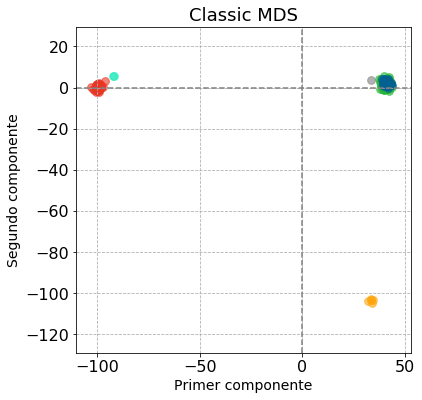

In [35]:
# Instancia del LDA
lda = LinearDiscriminantAnalysis(n_components = 2)
# Etiquetas que servirán para determinar la clase a la que pertenece cada observación
_labels = df_prot.Labels_conf
# Ejecutamos el análisis utilizando únicamente los carbonos alfa
_mask = '@CA'

# obtenemos las dos primeras dimensiones del análisis
reduced_lda = get_new_dimentions(lda, traj_crystals, atom_mask = _mask, 
                                 supervised = True, y = _labels, copy_obj= False)
# Realizamos la proyección
plt.figure(figsize = (6, 6))
plot_points(mds = reduced_lda.T, labels = df_prot.Labels_conf)

Obtenemos la varianza explicada de cada una de las dimensiones

In [36]:
lda.explained_variance_ratio_

array([0.94780584, 0.03223186])

Ahora obtenemos el peso de cada variable en cada una de las $n$ dimensiones.
En este caso, por default, LDA calcula $k - 1$ dimensiones, donde $k$ es el número de clases que recibe en el párametro $y$.  
Recordar que el número de variables evaluadas es igual al $\# atomos*3$.

In [41]:
# Valores en la dimensión 1
atoms_scalings_d1 = lda.scalings_.T[0]
print(F'El número de variables evaluadas es: {len(atoms_scalings_d1)}.')

El número de variables evaluadas es: 894.


Ahora reestructuramos el arreglo de pesos de las variables en la dimesión 1 a un arreglo de nAtomos\*3,
para así asignar los pesos de las tres coordenadas a su átomo respectivo, tal que se a posible determinar qué átomo contribuye más a las dimensiones del LDA.

Después, generamos un nuevo arreglo por átomos en el que a cada átomo se le sume el cuadrado de los desplazamientos de cada uno de sus valores en las tres coordenadas.

In [42]:
n_atoms_ = len(atoms_scalings_d1)/3
atoms_scalings_d1_resahped = atoms_scalings_d1.reshape((int(n_atoms_), 3))

atom_lda_weights_ = np.sum(atoms_scalings_d1_resahped**2, axis=1)
atom_lda_weights_

array([0.03068702, 0.16042912, 0.46038782, ..., 0.02215896, 0.01506753,
       0.03965601])

### Observamos la distribución de los valores de los pesos

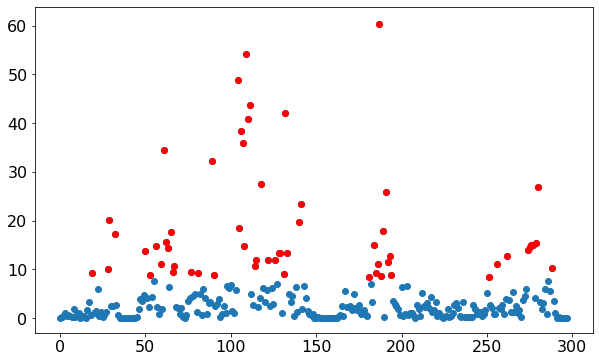

Número de residuos/átomos seleccionados: 59


In [102]:
plt.figure(figsize = (10, 6))

df_atom_w = pd.DataFrame({'resid_index': range(len(atom_lda_weights_)), 
                          'atom_weight': atom_lda_weights_})
plt.scatter(x = df_atom_w.resid_index, y = df_atom_w.atom_weight)

_cutoff = 8
_filtro = df_atom_w.atom_weight > _cutoff
plt.scatter(x = df_atom_w.resid_index[_filtro], y = df_atom_w.atom_weight[_filtro], c = 'red')
plt.show()
print(F'Número de residuos/átomos seleccionados: {len(df_atom_w.atom_weight[_filtro])}')

### Lista de resiudos seleccionados

In [103]:
residues_list = df_atom_w.atom_weight[_filtro].index.to_list()
# Lista en formato string para usar como parámetro en la visualización
str_residues_list = ':' + ', '.join(map(str, residues_list))
str_residues_list

':19, 28, 29, 32, 50, 53, 56, 59, 61, 62, 63, 65, 66, 67, 77, 81, 89, 90, 104, 105, 106, 107, 108, 109, 110, 111, 114, 115, 118, 122, 126, 128, 129, 131, 132, 133, 140, 141, 181, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 251, 256, 262, 274, 275, 276, 277, 279, 280, 288'

### Visualización en la estructura de la proteína

In [63]:
import nglview as nv
from nglview.color import ColormakerRegistry
import pytraj as pyt

_ColormakerRegistry()

In [74]:
path_to_structure = '../../ARCHIVOS/CRISTALES/PROT_CDK2_PREPARADAS/PREP_ALL_ENSAMBLE/1fin_ENS.pdb'.split('/')
ref_structure = pyt.load(os.path.join(*path_to_structure))

In [105]:
# Se crea el esquema de color para incluir a los residuos o átomos a resaltar
cm = ColormakerRegistry
cm.add_selection_scheme('cd', [['red', str_residues_list]])
# Se crea la visualización de la proteína
view = nv.show_pytraj(ref_structure)
view.clear()
view.add_cartoon(color = 'cd')
view

NGLWidget()

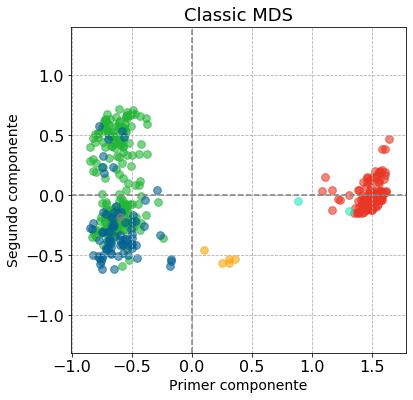

In [104]:
from modules.MDS import cMDS
mask_lda = str_residues_list
pyt.align(traj_crystals, mask_lda)
rmsd_pairs = pyt.pairwise_rmsd(traj = traj_crystals, mask = mask_lda, metric="rms")

mds_total = cMDS(rmsd_pairs)
plt.figure(figsize = (6,6))
plot_points(mds = mds_total[0], labels = df_prot.Labels_conf)

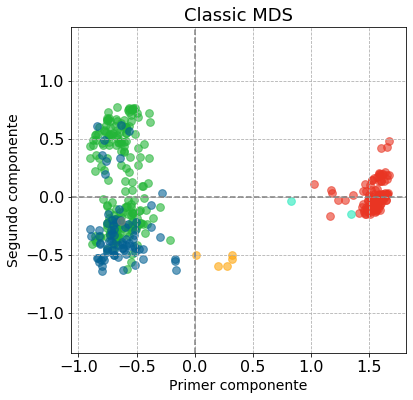

In [77]:
### 